In [1]:
import pysensors as ps
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Circle

plt.rc('figure.subplot', left=.2, right=.8, bottom=.2, top=.8)

### Load the Olivetti Dataset

In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
faces = datasets.fetch_olivetti_faces(shuffle=True, random_state=99)
X = faces.data

n_samples, n_features = X.shape
print(n_samples, n_features)

400 4096


In [4]:
# Global centering
X = X - X.mean(axis=0)

# Local centering
X -= X.mean(axis=1).reshape(n_samples, -1)

In [5]:
# From https://scikit-learn.org/stable/auto_examples/decomposition/plot_faces_decomposition.html
n_row, n_col = 2, 3
n_components = n_row * n_col
image_shape = (64, 64)

def plot_gallery(title, images, n_col=n_col, n_row=n_row, cmap=plt.cm.gray):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=cmap,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

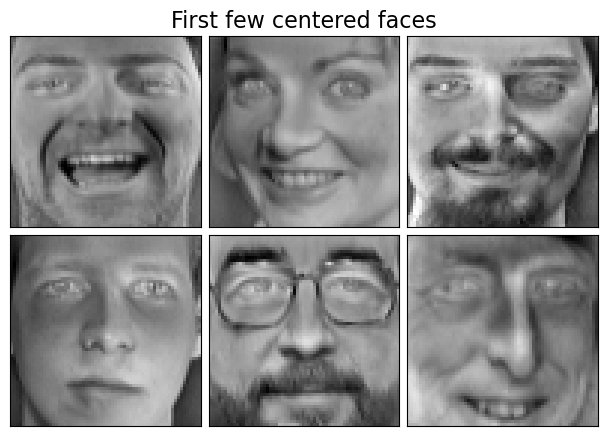

In [6]:
plot_gallery("First few centered faces", X[:n_components])

In [7]:
X_train, X_test = X[:300], X[300:]

### Unconstrained sensor placaement:

In [8]:
n_sensors = 10
n_modes = 10
basis_unconst = ps.basis.SVD(n_basis_modes = n_modes)
optimizer_unconst = ps.optimizers.QR()
model_unconst = ps.SSPOR(basis = basis_unconst, optimizer = optimizer_unconst, n_sensors = n_sensors)
model_unconst.fit(X_train)
all_sensors_unconst = model_unconst.get_all_sensors()
sensors_unconst = model_unconst.get_selected_sensors()

/Users/karnn/projects/pysensors/pysensors/reconstruction/_sspor.py:517: UserWarning: Number of sensors exceeds number of samples, which may cause CCQR to select sensors in constrained regions.
  warnings.warn(


In [9]:
xTopUnc = np.mod(sensors_unconst,np.sqrt(n_features))
yTopUnc = np.floor(sensors_unconst/np.sqrt(n_features))
xAllUnc = np.mod(all_sensors_unconst,np.sqrt(n_features))
yAllUnc = np.floor(all_sensors_unconst/np.sqrt(n_features))

In [10]:
#Sensor ID corresponds to the column number chosen
columns = ['Sensor ID','SensorX','sensorY'] 
unconstrainedSensors_df = pd.DataFrame(data = np.vstack([sensors_unconst,xTopUnc,yTopUnc]).T,columns=columns,dtype=int)
unconstrainedSensors_df.head(n_sensors)

,Sensor ID,SensorX,sensorY
0,4032,0,63
1,594,18,9
2,384,0,6
3,878,46,13
4,446,62,6
5,2772,20,43
6,4041,9,63
7,3936,32,61
8,340,20,5
9,2273,33,35


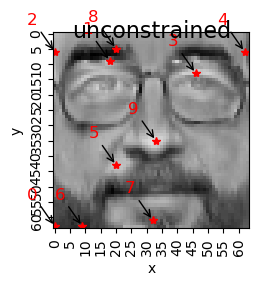

In [11]:
# Plot the constrained region and the unconstrained sensors where 1 is the first sensor chosen.
image = X_train[4,:].reshape(1,-1)

plot_gallery('unconstrained', image, n_col=1, n_row=1, cmap=plt.cm.gray)
plt.plot(xTopUnc, yTopUnc,'*r')
plt.xlabel('x')
plt.ylabel('y')
plt.xticks(np.arange(0,64,5),rotation=90)
plt.yticks(np.arange(0,64,5),rotation=90)
for ind,i in enumerate(range(len(xTopUnc))):
    plt.annotate(f"{str(ind)}",(xTopUnc[i],yTopUnc[i]),xycoords='data',
                 xytext=(-20,20), textcoords='offset points',color="r",fontsize=12,
                 arrowprops=dict(arrowstyle="->", color='black'))

#### Defining multiple constraint regions

In [12]:
### Region 1:
xmin1 = 20
xmax1 = 40
ymin1 = 10
ymax1 = 40
sensors_constrained1 = ps.utils._constraints.get_constraind_sensors_indices(xmin1,xmax1,ymin1,ymax1,image_shape[0],image_shape[1],all_sensors_unconst) #Constrained column indices 

### Region 2:
xmin2 = 10
xmax2 = 15
ymin2 = 10
ymax2 = 40
sensors_constrained2 = ps.utils._constraints.get_constraind_sensors_indices(xmin2,xmax2,ymin2,ymax2,image_shape[0],image_shape[0],all_sensors_unconst) #Constrained column indices 

### Region 2:
xmin3 = 40
xmax3 = 50
ymin3 = 10
ymax3 = 40
sensors_constrained3 = ps.utils._constraints.get_constraind_sensors_indices(xmin3,xmax3,ymin3,ymax3,image_shape[0],image_shape[0],all_sensors_unconst) #Constrained column indices 

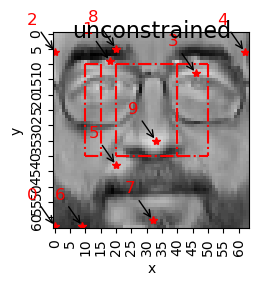

In [13]:
# Plot the constrained region and the unconstrained sensors where 1 is the first sensor chosen.
image = X[4,:].reshape(1,-1)

plot_gallery('unconstrained', image, n_col=1, n_row=1, cmap=plt.cm.gray)
plt.plot([xmin1,xmin1],[ymin1,ymax1],'-.r')
plt.plot([xmin1,xmax1],[ymax1,ymax1],'-.r')
plt.plot([xmax1,xmax1],[ymin1,ymax1],'-.r')
plt.plot([xmin1,xmax1],[ymin1,ymin1],'-.r')
plt.plot([xmin2,xmin2],[ymin2,ymax2],'-.r')
plt.plot([xmin2,xmax2],[ymax2,ymax2],'-.r')
plt.plot([xmax2,xmax2],[ymin2,ymax2],'-.r')
plt.plot([xmin2,xmax2],[ymin2,ymin2],'-.r')
plt.plot([xmin3,xmin3],[ymin3,ymax3],'-.r')
plt.plot([xmin3,xmax3],[ymax3,ymax3],'-.r')
plt.plot([xmax3,xmax3],[ymin3,ymax3],'-.r')
plt.plot([xmin3,xmax3],[ymin3,ymin3],'-.r')
plt.plot(xTopUnc, yTopUnc,'*r')
plt.xlabel('x')
plt.ylabel('y')
plt.xticks(np.arange(0,64,5),rotation=90)
plt.yticks(np.arange(0,64,5),rotation=90)
for ind,i in enumerate(range(len(xTopUnc))):
    plt.annotate(f"{str(ind)}",(xTopUnc[i],yTopUnc[i]),xycoords='data',
                 xytext=(-20,20), textcoords='offset points',color="r",fontsize=12,
                 arrowprops=dict(arrowstyle="->", color='black'))

#### Now we want to place a max of 1 sensor in Region 1 and exactly 2 in the Region 2. The rest of the sensors should be outside the constraint regions. 

In [14]:
# Define the number of constrained sensors allowed (s)
n_const_sensors = [[1,'max_n'],[2,'exact_n'],[2,'exact_n']]
# Define the GQR optimizer for the exact_n sensor placement strategy
optimizer_multiple = ps.optimizers.GQR()
opt_multiple_kws={'idx_constrained':[[sensors_constrained1],[sensors_constrained2],[sensors_constrained3]],
         'n_sensors':n_sensors,
         'n_const_sensors':n_const_sensors,
         'all_sensors':all_sensors_unconst,
         'constraint_option':"multiple_constraint_regions"}
basis_multiple = ps.basis.SVD(n_basis_modes=n_sensors)

In [15]:
# Initialize and fit the model
model_multiple = ps.SSPOR(basis = basis_multiple, optimizer = optimizer_multiple, n_sensors = n_sensors)
model_multiple.fit(X_train,**opt_multiple_kws)

# sensor locations based on columns of the data matrix
top_sensors_multiple = model_multiple.get_selected_sensors()

# sensor locations based on pixels of the image
xTopConst = np.mod(top_sensors_multiple,np.sqrt(n_features))
yTopConst = np.floor(top_sensors_multiple/np.sqrt(n_features))

print('The list of sensors selected is: {}'.format(top_sensors_multiple))

[1, 0, 1]
[0, 2, 1]
[(array([9]),), (array([], dtype=int64),), (array([3]),)]
['max_n', 'exact_n', 'exact_n']
[1, 0, 1]
[0, 2, 1]
[(array([9]),), (array([], dtype=int64),), (array([3]),)]
['max_n', 'exact_n', 'exact_n']
[1, 0, 1]
[0, 2, 1]
[(array([9]),), (array([], dtype=int64),), (array([3]),)]
['max_n', 'exact_n', 'exact_n']
[1, 0, 1]
[0, 2, 1]
[(array([9]),), (array([], dtype=int64),), (array([3]),)]
['max_n', 'exact_n', 'exact_n']
[1, 0, 1]
[0, 2, 1]
[(array([9]),), (array([], dtype=int64),), (array([3]),)]
['max_n', 'exact_n', 'exact_n']
[1, 0, 1]
[0, 2, 1]
[(array([9]),), (array([], dtype=int64),), (array([3]),)]
['max_n', 'exact_n', 'exact_n']
[1, 0, 1]
[0, 2, 1]
[(array([9]),), (array([], dtype=int64),), (array([3]),)]
['max_n', 'exact_n', 'exact_n']
[1, 0, 1]
[0, 2, 1]
[(array([9]),), (array([], dtype=int64),), (array([3]),)]
['max_n', 'exact_n', 'exact_n']
[1, 0, 1]
[0, 2, 1]
[(array([9]),), (array([], dtype=int64),), (array([3]),)]
['max_n', 'exact_n', 'exact_n']
[1, 0, 1]


/Users/karnn/projects/pysensors/pysensors/reconstruction/_sspor.py:517: UserWarning: Number of sensors exceeds number of samples, which may cause CCQR to select sensors in constrained regions.
  warnings.warn(


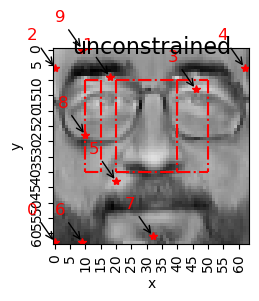

In [16]:
plot_gallery('unconstrained', image, n_col=1, n_row=1, cmap=plt.cm.gray)
plt.plot([xmin1,xmin1],[ymin1,ymax1],'-.r')
plt.plot([xmin1,xmax1],[ymax1,ymax1],'-.r')
plt.plot([xmax1,xmax1],[ymin1,ymax1],'-.r')
plt.plot([xmin1,xmax1],[ymin1,ymin1],'-.r')
plt.plot([xmin2,xmin2],[ymin2,ymax2],'-.r')
plt.plot([xmin2,xmax2],[ymax2,ymax2],'-.r')
plt.plot([xmax2,xmax2],[ymin2,ymax2],'-.r')
plt.plot([xmin2,xmax2],[ymin2,ymin2],'-.r')
plt.plot([xmin3,xmin3],[ymin3,ymax3],'-.r')
plt.plot([xmin3,xmax3],[ymax3,ymax3],'-.r')
plt.plot([xmax3,xmax3],[ymin3,ymax3],'-.r')
plt.plot([xmin3,xmax3],[ymin3,ymin3],'-.r')
plt.plot(xTopConst, yTopConst,'*r')
plt.xlabel('x')
plt.ylabel('y')
plt.xticks(np.arange(0,64,5),rotation=90)
plt.yticks(np.arange(0,64,5),rotation=90)
for ind,i in enumerate(range(len(xTopConst))):
    plt.annotate(f"{str(ind)}",(xTopConst[i],yTopConst[i]),xycoords='data',
                 xytext=(-20,20), textcoords='offset points',color="r",fontsize=12,
                 arrowprops=dict(arrowstyle="->", color='black'))